Include source package

In [1]:
# switch to the project directory
%cd ..
# working directory should be ../FSE

/home/mkabus/pdi


In [2]:
import sys
import os
module_path = os.path.abspath('src')

if module_path not in sys.path:
    sys.path.append(module_path)

Experiment definition

In [3]:
import os
import pandas as pd
import numpy as np

from pdi.data.preparation import FeatureSetPreparation, MeanImputation, DeletePreparation, RegressionImputation, EnsemblePreparation
from pdi.constants import PARTICLES_DICT, TARGET_CODES, NUM_WORKERS, P_RANGE, P_RESOLUTION
from pdi.models import NeuralNet, NeuralNetEnsemble, AttentionModel, Traditional
from pdi.data.types import Split, Additional
from pdi.data.utils import DataPreparation
from pdi.evaluate import calculate_precision_recall, get_predictions_data_and_loss, get_nsigma_predictions_data

EXPERIMENTS = {
    #"Mean": {
    #    "model_class": NeuralNet,
    #    "data": {
    #        "all": MeanImputation,
    #        "complete_only": DeletePreparation,
    #    }
    #},
    #"Regression": {
     #   "model_class": NeuralNet,
    #    "data": {
     #      "all": RegressionImputation,
    #        "complete_only": DeletePreparation,
    #    }
    #},
    #"Ensemble": {
    #    "model_class": NeuralNetEnsemble,
    #    "data": {
    #        "all": EnsemblePreparation,
    #        "complete_only": lambda: EnsemblePreparation(complete_only=True),
    #    }
    #},
    #"Proposed": {
    #    "model_class": AttentionModel,
    #    "data": {
    #        "all": FeatureSetPreparation,
    #        "complete_only": lambda: FeatureSetPreparation(complete_only=True),
    #    }
    #},
    #"Delete": {
    #    "model_class": NeuralNet,
    #    "data": {
    #        "complete_only": DeletePreparation,
    #    }
    #},
    "NSigma": {
        "model_class": Traditional,
        "data": {
            "all": DataPreparation,
            "complete_only": DeletePreparation,
        }
    },
}

particle_names = [PARTICLES_DICT[i] for i in TARGET_CODES]
model_names = EXPERIMENTS.keys()
metrics = ["precision", "recall", "f1"]
data_types = ["all", "complete_only"]

Evaluate pretrained models on test datasets

In [4]:
import torch
import torch.multiprocessing

torch.multiprocessing.set_sharing_strategy('file_system')

device = torch.device("cpu")

metric_results = pd.DataFrame(
    index=pd.MultiIndex.from_product(
        [particle_names, model_names], names=["particle", "model"]
        ),
    columns=pd.MultiIndex.from_product(
        [data_types, metrics], names=["data", "metric"]
        ),
    )

prediction_data = {}

print(TARGET_CODES)

for target_code in TARGET_CODES:
    print(f"Target: {target_code}")
    particle_name = PARTICLES_DICT[target_code]
    for experiment_name, exp_dict in EXPERIMENTS.items():
        print(f"Experiment: {experiment_name}")
        if exp_dict["model_class"] != Traditional:
            load_path = f"models/{experiment_name}/{particle_name}.pt"
            saved_model = torch.load(load_path)
            model = exp_dict["model_class"](*saved_model["model_args"]).to(device)
            model.thres = saved_model["model_thres"]
            model.load_state_dict(saved_model["state_dict"])

        batch_size = 512

        prediction_data[experiment_name] = {}
        for data_type, data_prep in exp_dict["data"].items():
            print(f"Data type: {data_type}")
            test_loader, = data_prep().prepare_dataloaders(batch_size, NUM_WORKERS, [Split.TEST])
            
            if exp_dict["model_class"] != Traditional:
                model_thres = model.thres
                predictions, targets, add_data, _ = get_predictions_data_and_loss(model, test_loader, device)
                selected = predictions > model.thres
            else:
                model_thres = 3.0
                predictions, targets, add_data = get_nsigma_predictions_data(test_loader, target_code)
                selected = predictions < model_thres
                print(predictions)
                print(targets)
                print(selected)

            binary_targets = targets == target_code

            true_positives = int(np.sum(selected & binary_targets))
            selected_positives = int(np.sum(selected))
            positives = int(np.sum(binary_targets))

            precision, recall, _, _ = calculate_precision_recall(true_positives, selected_positives, positives)
            f1 = 2 * precision * recall / (precision + recall + np.finfo(float).eps)

            metric_results.loc[(particle_name, experiment_name), data_type] = precision, recall, f1
            
            prediction_data[experiment_name][data_type] = {
                "targets": binary_targets,
                "predictions": predictions,
                "momentum": add_data[Additional.fP.name],
                "threshold": model_thres
            }

# In the future: make it more elegant, using input with iloc instead of Additional data_dict

[211, 2212, 321, -211, -2212, -321]
Target: 211
Experiment: NSigma
Data type: all


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:52<00:00, 63.62it/s]


[2.4028224e-01 7.2714165e+01 4.1749704e-01 ... 8.1764621e-01 9.9900092e+02
 1.3022215e+00]
[ 211. 2212.  211. ...  211.  211.  211.]
[ True False  True ...  True False  True]
Data type: complete_only


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:16<00:00, 72.47it/s]


[72.714165    0.41749704  1.7218826  ...  2.4089305   0.8535872
  1.3022215 ]
[2212.  211.  211. ...  321.  211.  211.]
[False  True  True ...  True  True  True]
Target: 2212
Experiment: NSigma
Data type: all


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:44<00:00, 74.66it/s]


[ 12.880764    1.3989351  53.922737  ...  13.038934  999.0521
  62.768623 ]
[ 211. 2212.  211. ...  211.  211.  211.]
[False  True False ... False False False]
Data type: complete_only


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:15<00:00, 77.44it/s]


[ 1.3989351 53.922737  10.503705  ...  2.1795416 11.97595   62.768623 ]
[2212.  211.  211. ...  321.  211.  211.]
[ True False False ...  True False False]
Target: 321
Experiment: NSigma
Data type: all


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:47<00:00, 70.35it/s]


[  9.809584  39.134804  25.65595  ...  10.244471 999.011     29.340178]
[ 211. 2212.  211. ...  211.  211.  211.]
[False False False ... False False False]
Data type: complete_only


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:18<00:00, 66.72it/s]


[39.134804  25.65595    4.522706  ...  0.7459588  7.9503965 29.340178 ]
[2212.  211.  211. ...  321.  211.  211.]
[False False False ...  True False False]
Target: -211
Experiment: NSigma
Data type: all


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:46<00:00, 72.05it/s]


[2.4028224e-01 7.2714165e+01 4.1749704e-01 ... 8.1764621e-01 9.9900092e+02
 1.3022215e+00]
[ 211. 2212.  211. ...  211.  211.  211.]
[ True False  True ...  True False  True]
Data type: complete_only


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:16<00:00, 76.62it/s]


[72.714165    0.41749704  1.7218826  ...  2.4089305   0.8535872
  1.3022215 ]
[2212.  211.  211. ...  321.  211.  211.]
[False  True  True ...  True  True  True]
Target: -2212
Experiment: NSigma
Data type: all


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:45<00:00, 73.61it/s]


[ 12.880764    1.3989351  53.922737  ...  13.038934  999.0521
  62.768623 ]
[ 211. 2212.  211. ...  211.  211.  211.]
[False  True False ... False False False]
Data type: complete_only


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:19<00:00, 64.07it/s]


[ 1.3989351 53.922737  10.503705  ...  2.1795416 11.97595   62.768623 ]
[2212.  211.  211. ...  321.  211.  211.]
[ True False False ...  True False False]
Target: -321
Experiment: NSigma
Data type: all


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 3316/3316 [00:44<00:00, 74.04it/s]


[  9.809584  39.134804  25.65595  ...  10.244471 999.011     29.340178]
[ 211. 2212.  211. ...  211.  211.  211.]
[False False False ... False False False]
Data type: complete_only


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1231/1231 [00:17<00:00, 72.11it/s]


[39.134804  25.65595    4.522706  ...  0.7459588  7.9503965 29.340178 ]
[2212.  211.  211. ...  321.  211.  211.]
[False False False ...  True False False]


Save metrics table

In [5]:
os.makedirs("reports/tables", exist_ok=True)
metric_results.to_csv(f"reports/tables/comparison_metrics_nsigma.csv")

Plot precision (purity) and recall (efficiency) comparison

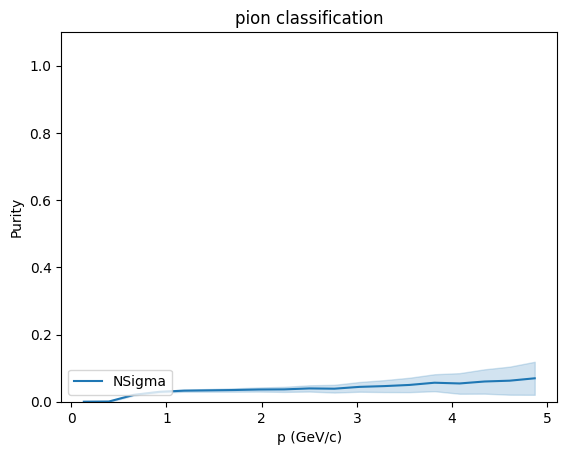

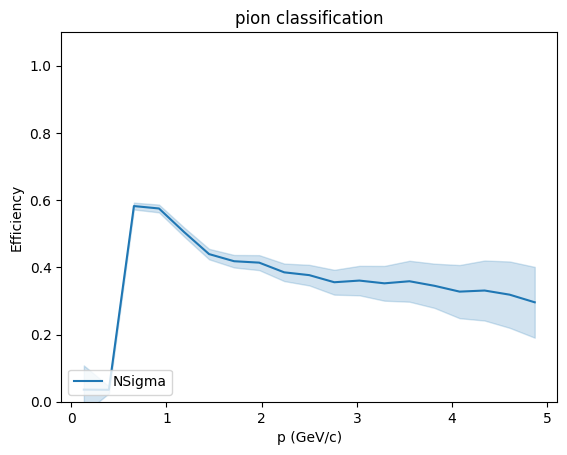

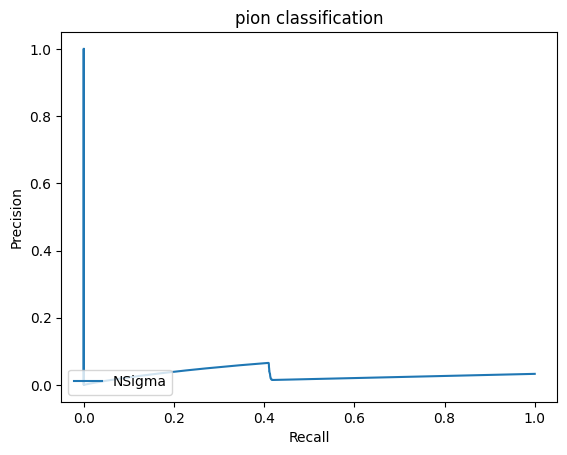

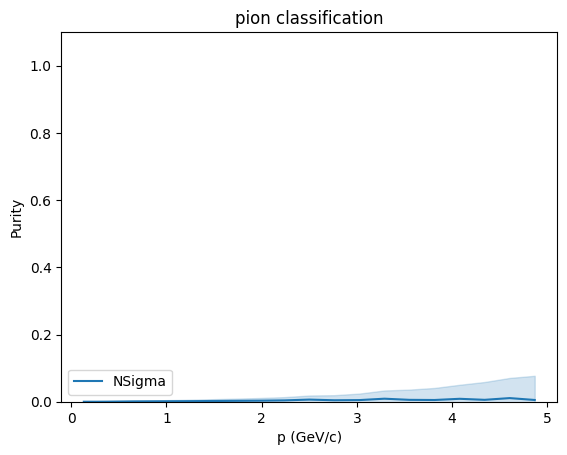

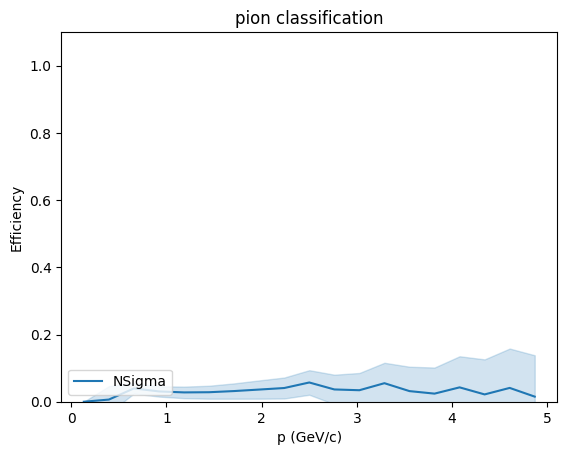

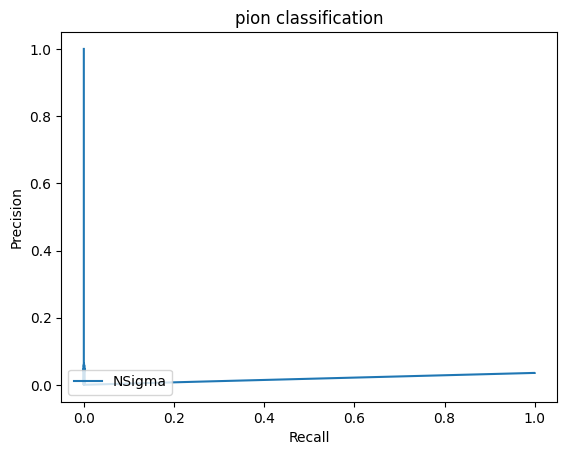

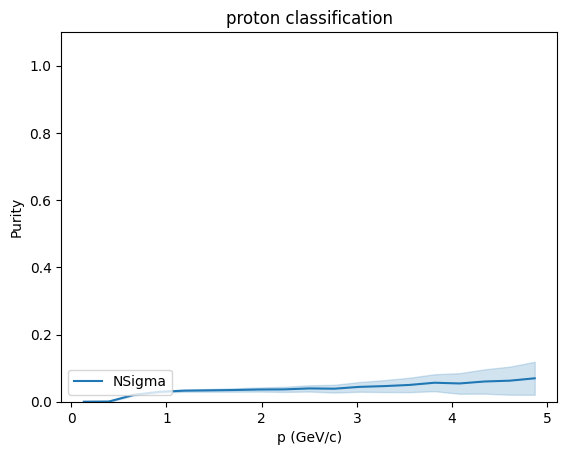

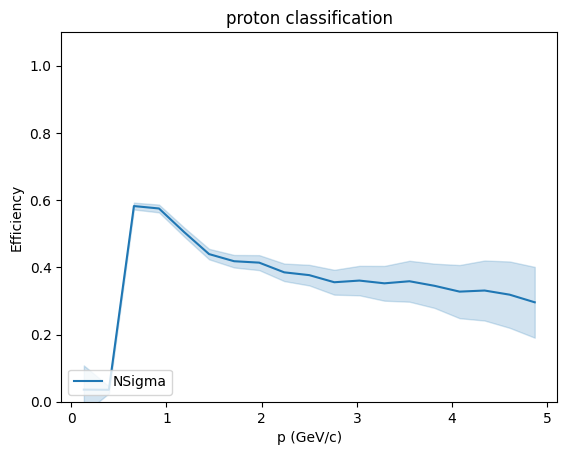

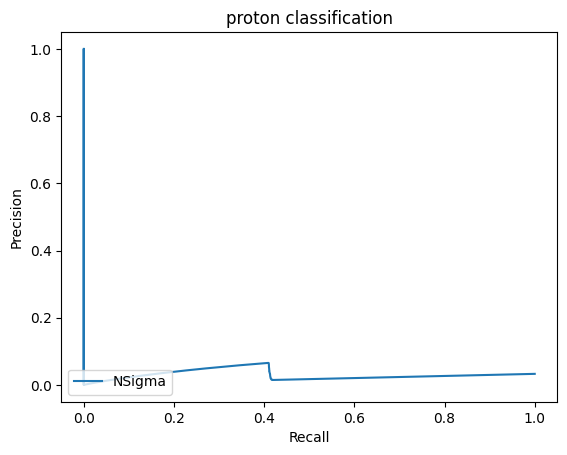

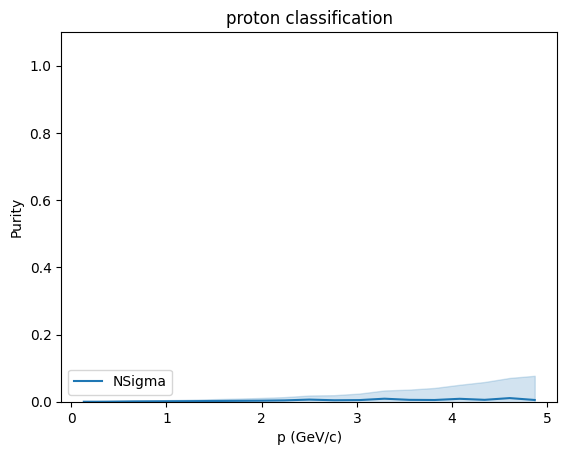

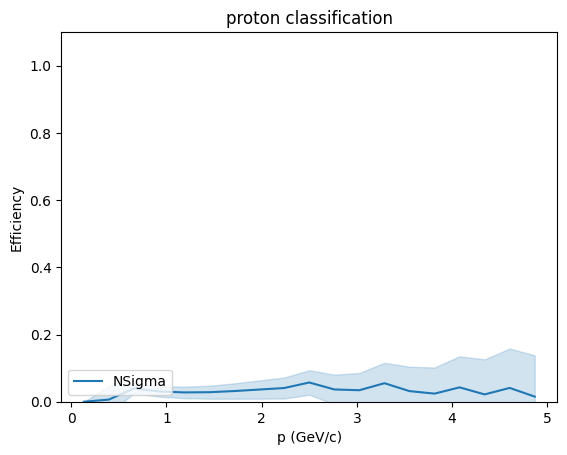

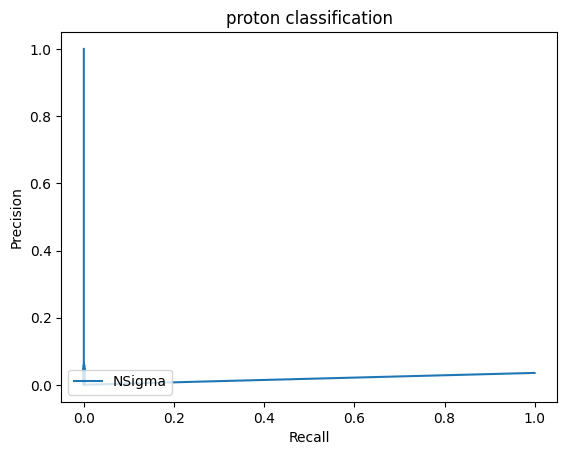

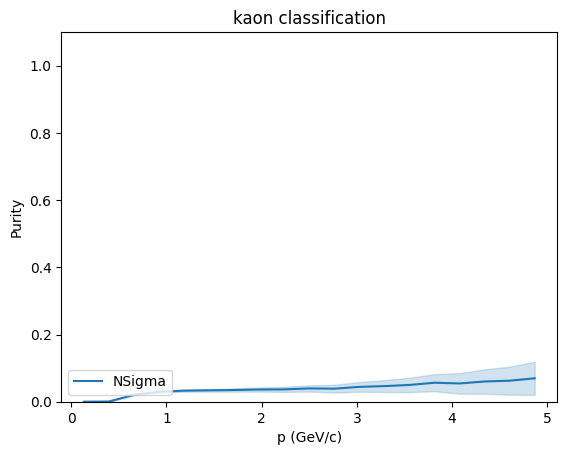

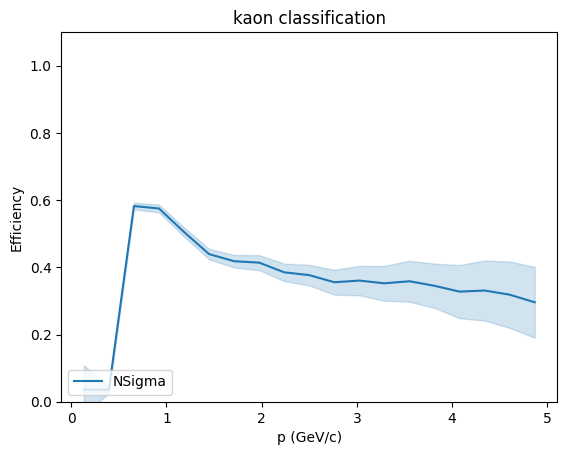

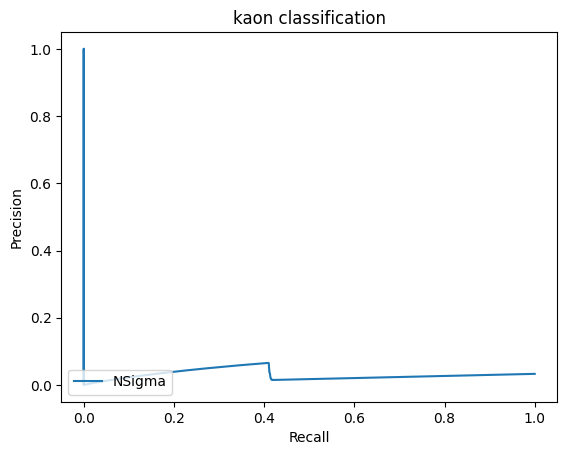

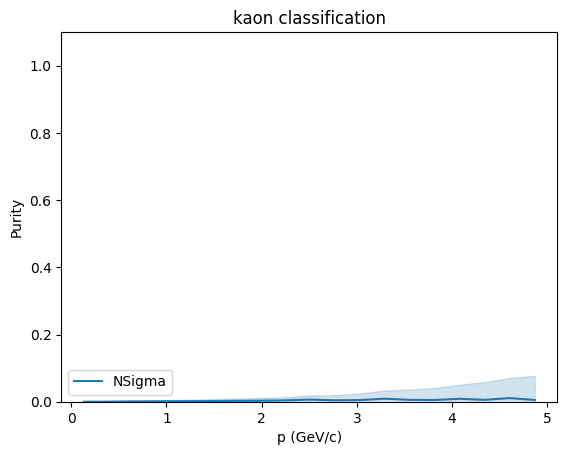

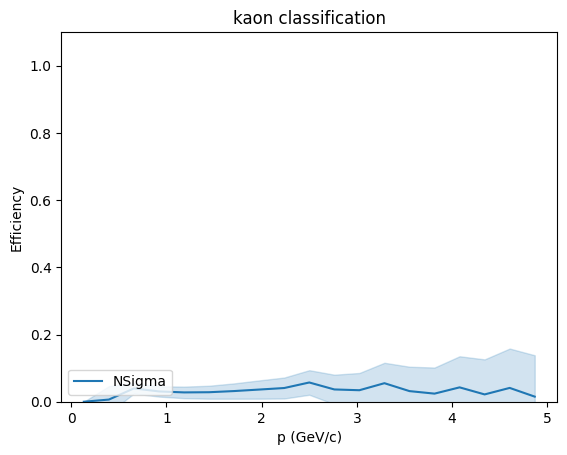

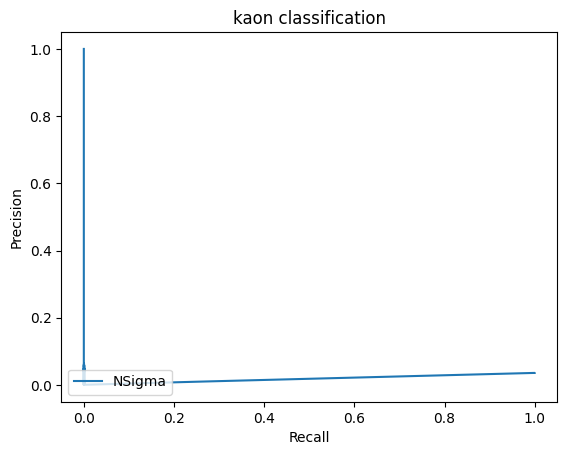

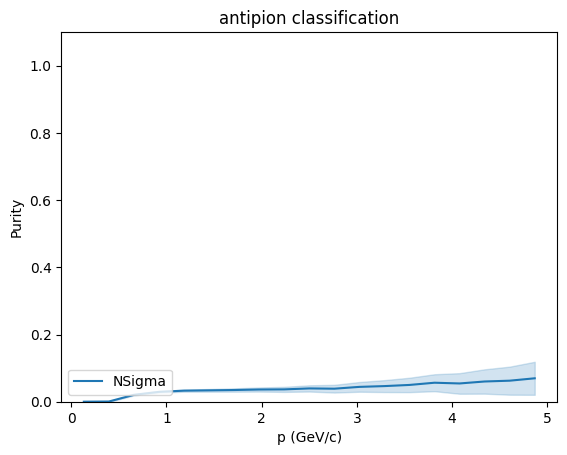

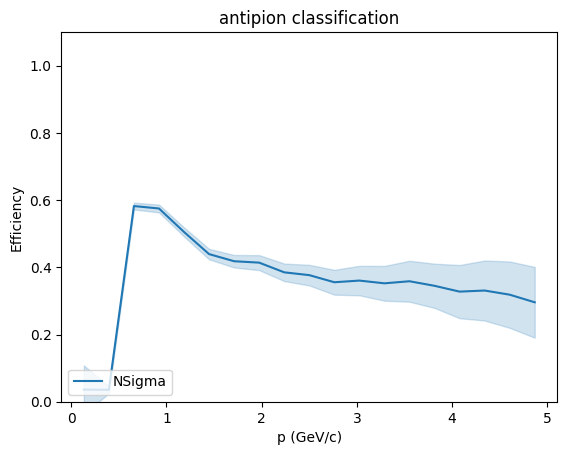

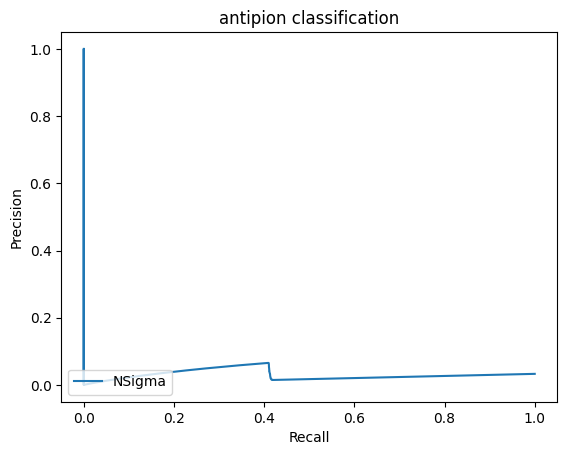

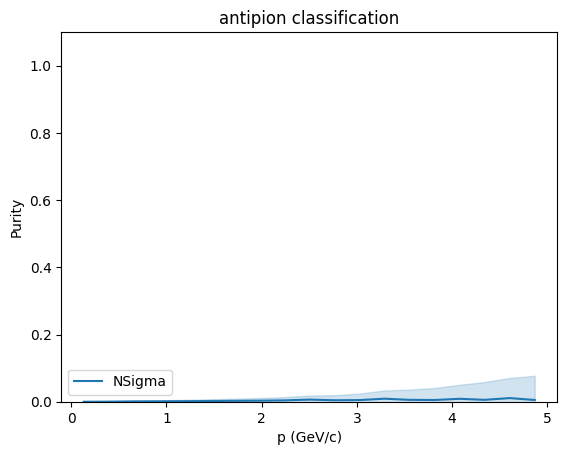

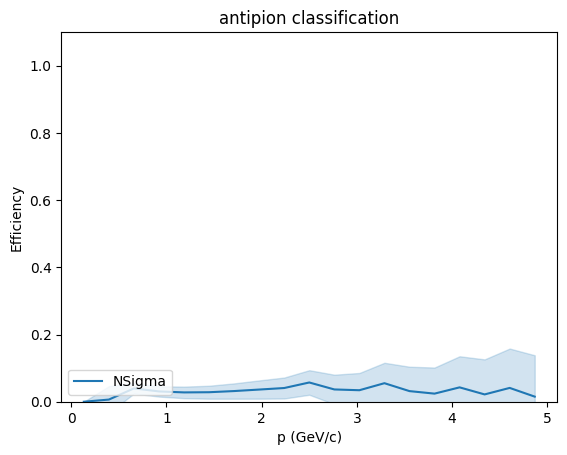

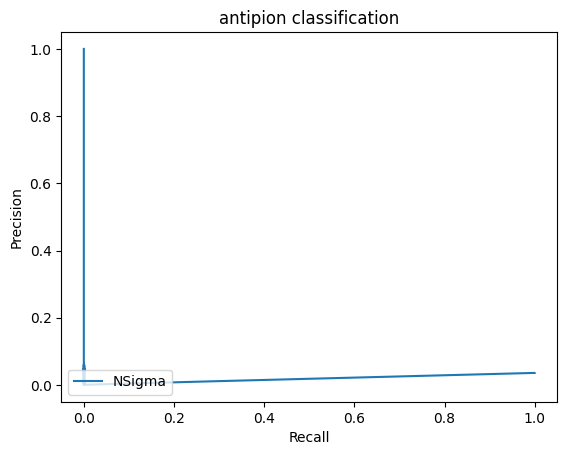

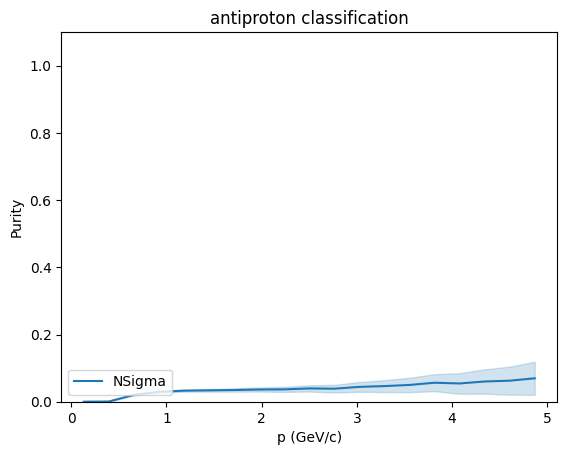

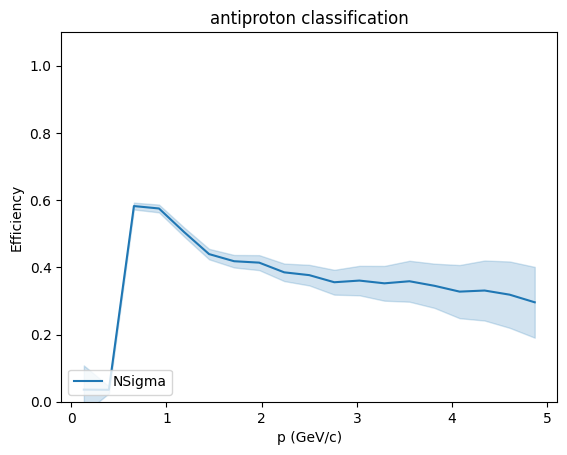

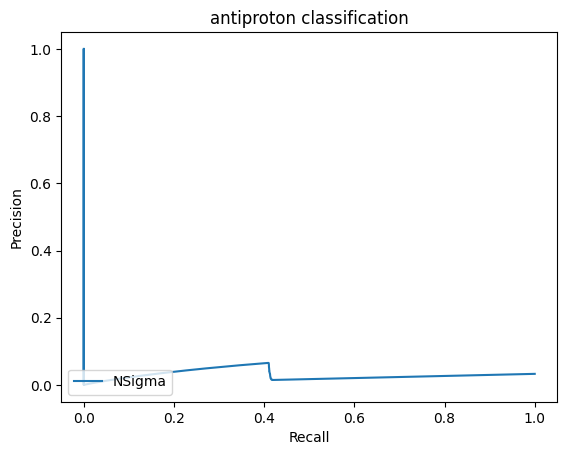

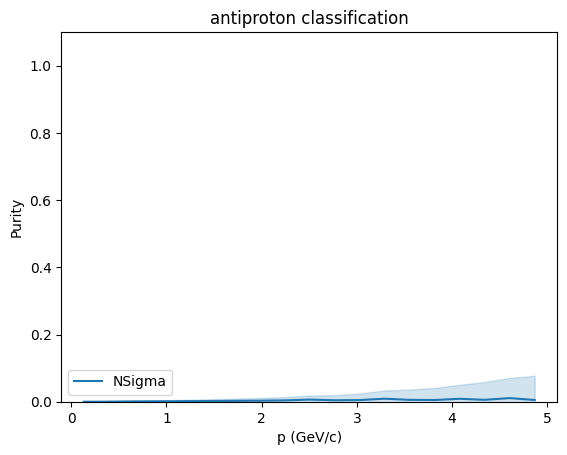

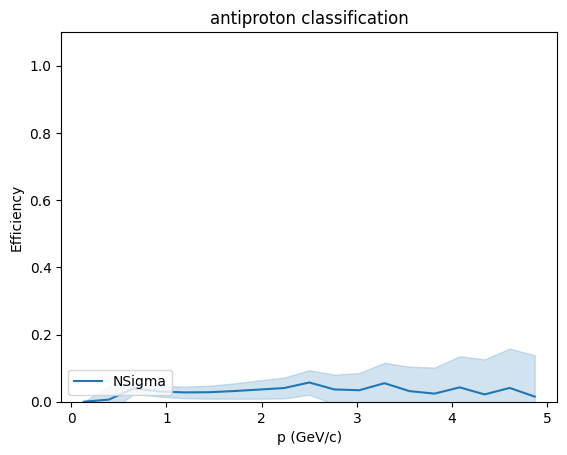

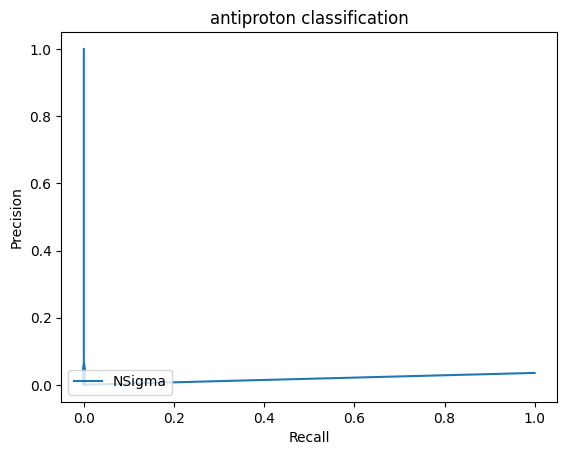

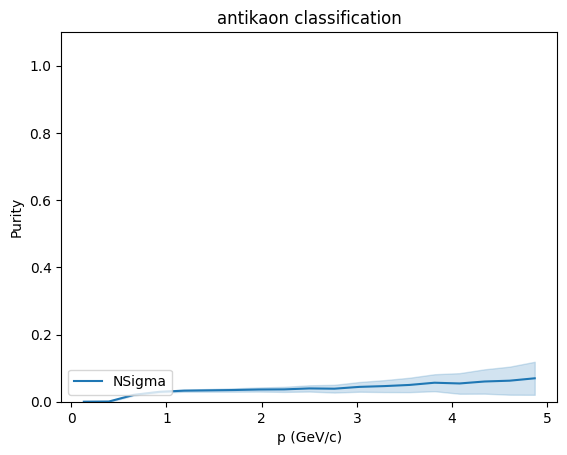

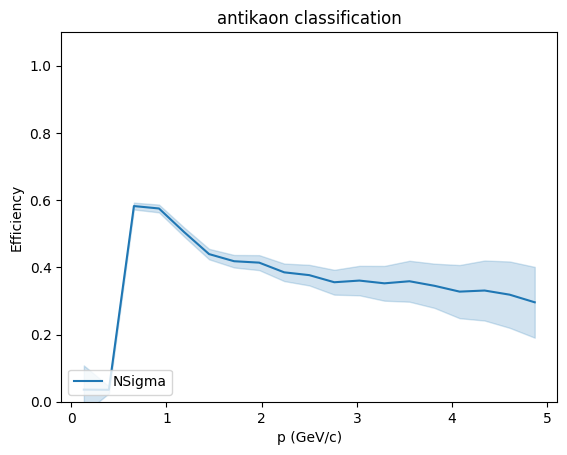

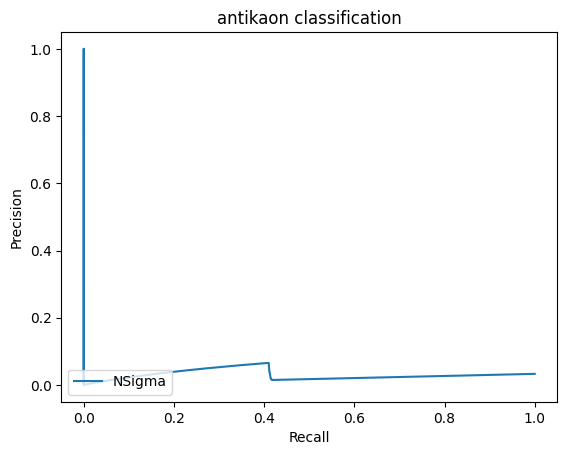

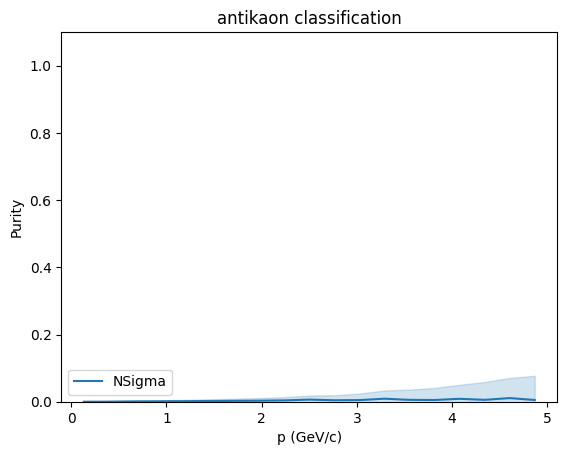

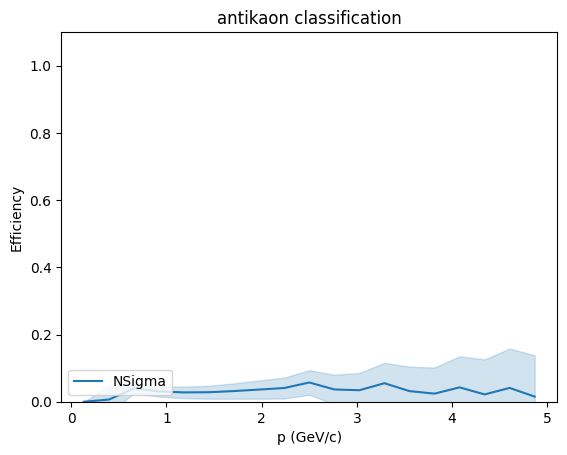

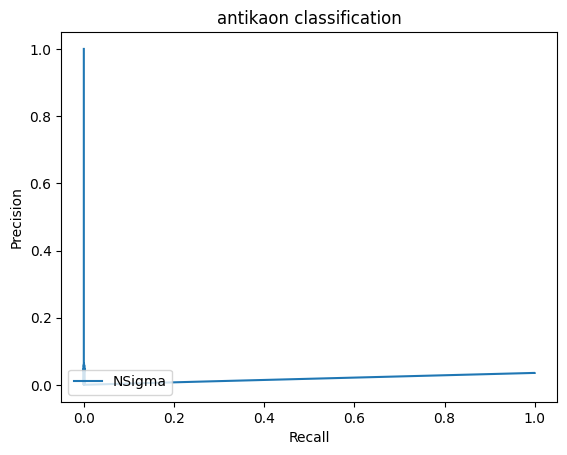

In [6]:
%matplotlib inline
from pdi.visualise import (
    plot_purity_comparison,
    plot_efficiency_comparison,
    plot_precision_recall_comparison,
)

p_min, p_max = P_RANGE
p_range = np.linspace(p_min, p_max, P_RESOLUTION)
intervals = list(zip(p_range[:-1], p_range[1:]))

for target_code in TARGET_CODES:
    particle_name = PARTICLES_DICT[target_code]
    for data_type in data_types:
        data = {}
        for exp_name, exp_dict in prediction_data.items():
            if data_type in exp_dict:
                data[exp_name] = exp_dict[data_type]

        save_dir = f"reports/figures/comparison_{data_type}_nsigma/{particle_name}"   
        os.makedirs(save_dir, exist_ok=True)
        plot_purity_comparison(particle_name, data, intervals, save_dir)
        plot_efficiency_comparison(particle_name, data, intervals, save_dir)
        plot_precision_recall_comparison(particle_name, data, save_dir)



Create LaTeX table from metrics file

In [7]:
df = pd.read_csv(f"reports/tables/comparison_metrics_nsigma.csv",
                 index_col=[0, 1],
                 header=[0, 1])
subsets = [((part, slice(None)), column) for column in df.columns
           for part in particle_names]

polish_model_names = {
    "Mean": "Średnia",
    "Regression": "Regresja",
    "Ensemble": "Zestaw",
    "Proposed": "Prop. rozw.",
    "Delete": "Usunięcie",
    "NSigma": "n-sigma"
}

polish_metrics = {
    "precision": "precyzja",
    "recall": "czułość",
    "f1": "f1",
}

eng_metrics = ["precision", "recall", "f1"]


for dt in data_types:
    save_dir = f"reports/tables/comparison_{dt}_nsigma"
    os.makedirs(save_dir, exist_ok=True)
    for particle in particle_names:
        results = df.xs(particle).xs(dt, axis='columns')
        #results = results.rename(index=polish_model_names, columns=polish_metrics)
        #results.columns.name = "metrics"
        #results.index.name = "model"
        # results.columns.rename(polish_metrics)
        columns = [(slice(None), column) for column in eng_metrics]
        style = results.style
        style.format(precision=4)
        for column in columns:
            style = style.highlight_max(column, props='textbf:--rwrap')
        style.to_latex(f"{save_dir}/{particle}_results.tex",
                       hrules=True,
                       clines="all;data")
